In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)

In [2]:
# Get and decode MNIST dataset
import gzip
import os

def fetch_mnist(filename):
    path = os.path.join("data", "digits", filename)
    if not os.path.isdir("data/digits"):
        os.makedirs("data/digits", exist_ok=True)
    if not os.path.isfile(path):
        import requests
        url = f"http://yann.lecun.com/exdb/mnist/{filename}"
        data = requests.get(url).content
        with open(path, "wb") as f:
            f.write(data)
    else:
        with open(path, "rb") as f:
            data = f.read()
    return np.frombuffer(gzip.decompress(data), dtype=np.uint8).copy()

X_train = fetch_mnist("train-images-idx3-ubyte.gz")[0x10:].reshape(-1, 28, 28)
Y_train = fetch_mnist("train-labels-idx1-ubyte.gz")[0x8:]
X_test = fetch_mnist("t10k-images-idx3-ubyte.gz")[0x10:].reshape(-1, 28, 28)
Y_test = fetch_mnist("t10k-labels-idx1-ubyte.gz")[0x8:]

In [3]:
# Define model
from torch import nn
import torch.nn.functional as F

class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.l1 = nn.Linear(28*28, 128)
        self.act1 = nn.ReLU()
        self.l2 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = self.act1(self.l1(x))
        x = self.l2(x)
        return x

In [4]:
from tqdm import trange
BS = 64
EPOCHS = 20

def train(X_train, Y_train):
    losses = []
    model.train()
    size = len(X_train)
    steps = int(np.ceil(size / BS))
    for epoch in (t:=trange(EPOCHS)):
        epoch_loss = 0
        idx = np.random.permutation(size)
        for step in range(steps):
            samples = idx[step * BS: BS * (step + 1)]
            X = torch.Tensor(X_train[samples])
            y = torch.Tensor(Y_train[samples])
            pred = model(X.reshape(-1, 28*28))
            loss = loss_fn(pred, y.long())
            epoch_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        epoch_loss /= steps
        t.set_description(f"epoch loss: {epoch_loss}")
        losses.append(epoch_loss)
        
    plt.plot(losses)

In [5]:
def test(X_test, Y_test):
    model.eval()
    size = len(X_test)
    steps = int(np.ceil(size / BS))
    idx = np.random.permutation(size)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for step in range(steps):
            samples = idx[step * BS: BS * (step + 1)]
            X = torch.Tensor(X_test[samples])
            y = torch.Tensor(Y_test[samples])
            pred = model(X.reshape(-1, 28*28))
            test_loss += loss_fn(pred, y.long()).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        test_loss /= steps
        correct /= size
    return test_loss, correct

epoch loss: 0.031703500414211584: 100%|██████████| 20/20 [00:18<00:00,  1.10it/s]


(0.15639287062659624, 0.9635)

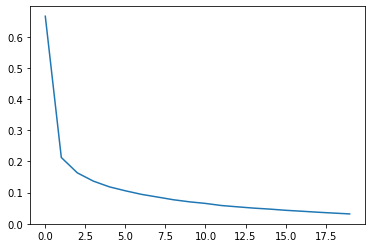

In [6]:
# Initialize model, train and test
model = MNISTNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
train(X_train, Y_train)
test(X_test, Y_test)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 6, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9])


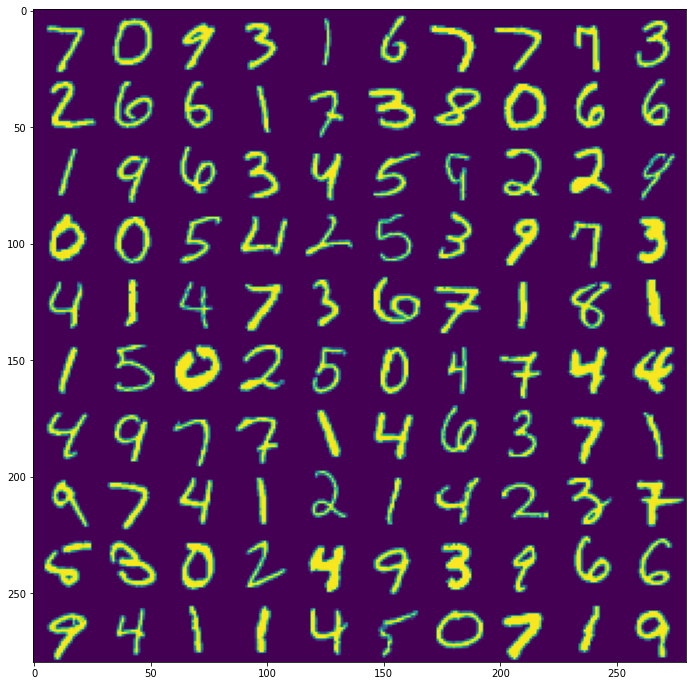

In [7]:
# Show a grid of numbers and their predictions
num = 10

plt.figure(figsize=(12, 12))
plt.imshow(np.hstack(X_test[0:num*num].reshape(num, 28*num, 28)))
out = model(torch.Tensor(X_test[0:num*num]).reshape(-1, 28*28))
print(torch.argmax(out, dim=1))

5


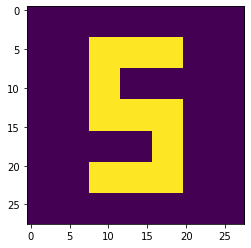

In [8]:
# Manual number design
img = np.asarray([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0],
])

img = np.repeat(np.repeat(img, 4, axis=1), 4, axis=0)
plt.imshow(img)

out = model(torch.Tensor(img).reshape(-1, 28*28))
print(out.argmax().item())